In [ ]:
# DATASET: https://www.kaggle.com/datasets/saurabhshahane/twitter-sentiment-dataset  (India)
# https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis  (Entities/empresas)

In [1]:
import re
import matplotlib.pyplot as plt
from nltk.tokenize.treebank import TreebankWordDetokenizer
from gensim.utils import simple_preprocess
import gensim
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
print('Done')

2022-10-13 12:40:00.543517: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-13 12:40:01.375597: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-13 12:40:01.375623: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-13 12:40:01.478638: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-13 12:40:03.260608: W tensorflow/stream_executor/platform/de

Done


In [4]:
train = pd.read_csv('../data/twitter_training.csv', names=['id', 'entity', 'sentiment', 'text'])
test = pd.read_csv('../data/twitter_validation.csv', names=['id', 'entity', 'sentiment', 'text'])
print(train.shape)
print(test.shape)

display(train.head())
display(test.head())

(74682, 4)
(1000, 4)


,id,entity,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


,id,entity,sentiment,text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


### Basic data cleaning

In [5]:
# checking missing values
train.isna().sum()

id             0
entity         0
sentiment      0
text         686
dtype: int64

In [6]:
# droping NAs since they are less then 1%
train.dropna(inplace=True)
train.isna().sum()

id           0
entity       0
sentiment    0
text         0
dtype: int64

In [10]:
# transforming to lower case for the next analysis
train['text'] = train['text'].str.lower()

In [15]:
# how many for each sentiment
train['sentiment'].value_counts()

Negative      22358
Positive      20655
Neutral       18108
Irrelevant    12875
Name: sentiment, dtype: int64

In [16]:
# removing all "irrelevant" since they don't help to build our model (we want to classify just among the other 3 labels)
train = train[train['sentiment'] != 'Irrelevant']
train['sentiment'].value_counts()

Negative    22358
Positive    20655
Neutral     18108
Name: sentiment, dtype: int64

In [19]:
# How's distributed the dataset? Is it biased?
train.groupby('sentiment').nunique()

,id,entity,text
sentiment,,,
Negative,3757,32,21154
Neutral,3053,32,17060
Positive,3472,32,19026


### Labels sanity check

Performing a quick inspection on random records to check if their labels make sense. If they don't, we can't train a decent model with them. 

In [17]:
samples = train.sample(10)
for idx, row in samples.iterrows():
    print(row['text'])
    print("-"*50)
    print(row['sentiment'])
    print("-"*50)
    print("")

pr @ea @eamaddennfl apparently my last name of ryan moore is less profane
--------------------------------------------------
Negative
--------------------------------------------------

i won 3 achievements in assassin's creed odyssey for 102 trueachievement pts trueachievements.com/gamer/outofthe…
--------------------------------------------------
Positive
--------------------------------------------------

im getting on borderlands and i will murder you all ,
--------------------------------------------------
Positive
--------------------------------------------------

@ ronnie2k @ nba2k how hard is it to make sure your developers stay up to date on hate speech, numbers and symbols? as a basketball fan and software developer, i'm disgusted. fix this! pic.twitter.com / ctqvq0il7x
--------------------------------------------------
Negative
--------------------------------------------------

microsoft - owned a minecraft i will stop using you amazon ’ ″ s online cloud teknoids. com / 20

### Potential issues found

- Most mentions to "Red Dead Redeeming" (a game) seem to be good but they have the word "dead". This can create a bias, associating the word "dead" with positive, which can be very confusing.

In [18]:
# replacing "red dead redeemption" by '' to remove confusion with word 'dead' and positive labels
train['text'] = train['text'].str.replace('red dead redemption', '')
train['text'] = train['text'].str.replace('red dead', '')

In [77]:
# Let's keep only the columns that we're going to use
train = train[['text','sentiment']]
train.head()

,text,sentiment
0,im getting on borderlands and i will murder yo...,Positive
1,i am coming to the borders and i will kill you...,Positive
2,im getting on borderlands and i will kill you ...,Positive
3,im coming on borderlands and i will murder you...,Positive
4,im getting on borderlands 2 and i will murder ...,Positive


### Preprocessing steps to be performed:
- Remove URLs from the tweets
- Tokenize text
- Remove emails
- Remove new lines characters
- Remove distracting single quotes
- Remove all punctuation signs
- Lowercase all text
- Detokenize text
- Convert list of texts to Numpy array

In [20]:
def preprocess_texts(data):
    
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
        
    return data

In [21]:
temp = []
#Splitting pd.Series to list
data_to_list = train['text'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(preprocess_texts(data_to_list[i]))
list(temp[:5])

['im getting on borderlands and i will murder you all ,',
 'i am coming to the borders and i will kill you all,',
 'im getting on borderlands and i will kill you all,',
 'im coming on borderlands and i will murder you all,',
 'im getting on borderlands 2 and i will murder you me all,']

In [22]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        

data_words = list(sent_to_words(temp))

print(data_words[:10])

[['im', 'getting', 'on', 'borderlands', 'and', 'will', 'murder', 'you', 'all'], ['am', 'coming', 'to', 'the', 'borders', 'and', 'will', 'kill', 'you', 'all'], ['im', 'getting', 'on', 'borderlands', 'and', 'will', 'kill', 'you', 'all'], ['im', 'coming', 'on', 'borderlands', 'and', 'will', 'murder', 'you', 'all'], ['im', 'getting', 'on', 'borderlands', 'and', 'will', 'murder', 'you', 'me', 'all'], ['im', 'getting', 'into', 'borderlands', 'and', 'can', 'murder', 'you', 'all'], ['so', 'spent', 'few', 'hours', 'making', 'something', 'for', 'fun', 'if', 'you', 'dont', 'know', 'am', 'huge', 'fan', 'and', 'maya', 'is', 'one', 'of', 'my', 'favorite', 'characters', 'so', 'decided', 'to', 'make', 'myself', 'wallpaper', 'for', 'my', 'pc', 'here', 'is', 'the', 'original', 'image', 'versus', 'the', 'creation', 'made', 'enjoy', 'pic', 'twitter', 'com', 'mlsi', 'wf', 'jg'], ['so', 'spent', 'couple', 'of', 'hours', 'doing', 'something', 'for', 'fun', 'if', 'you', 'dont', 'know', 'that', 'im', 'huge', '

In [23]:
len(data_words)

61121

In [24]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [25]:
data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
print(data[:5])

['im getting on borderlands and will murder you all', 'am coming to the borders and will kill you all', 'im getting on borderlands and will kill you all', 'im coming on borderlands and will murder you all', 'im getting on borderlands and will murder you me all']


In [26]:
data = np.array(data)

## Label encoding
As the dataset is categorical, we need to convert the sentiment labels from Neutral, Negative and Positive to a float type that our model can understand. To achieve this task, we'll implement the to_categorical method from Keras.

In [27]:
labels = np.array(train['sentiment'])
y = []
for i in range(len(labels)):
    if labels[i] == 'Neutral':
        y.append(0)
    if labels[i] == 'Negative':
        y.append(1)
    if labels[i] == 'Positive':
        y.append(2)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

In [29]:
labels

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

## Data sequencing and splitting

Implementing Keras tokenizer and its pad_sequences method to transform our text data into 3D float data, so that our neural networks can be trained on it.

In [78]:
import keras
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
import configparser
config = configparser.ConfigParser()
config.sections()
config.read('../config.ini')

max_len = int(config['model_params']['max_len'])
max_words = int(config['model_params']['max_words'])

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ... 1598   12   24]
 [   0    0    0 ...  417   12   24]
 [   0    0    0 ...  417   12   24]
 ...
 [   0    0    0 ...  132  697 2410]
 [   0    0    0 ...  127  697 2410]
 [   0    0    0 ...   62  697 2410]]


In [54]:
# persisting tokenizer to be used later by the inference module
from joblib import dump, load
dump(tokenizer, '../artifacts/keras_tokenizer.joblib')

['../artifacts/keras_tokenizer.joblib']

In [31]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(tweets,labels, test_size=.25, random_state=0, )
print (len(X_train),len(X_test),len(y_train),len(y_test))

45840 15281 45840 15281


# Model building
Building our Recurrent Neural Network. It will be a Bidirectional LSTM model.

### Bidirectional LTSM model

In [50]:
model = Sequential()
model.add(layers.Embedding(max_words, 40, input_length=max_len))
model.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model.add(layers.Dense(3,activation='softmax'))
model.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint2 = ModelCheckpoint("../models/BidLTSM.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model.fit(X_train, y_train, epochs=15,validation_data=(X_test, y_test),callbacks=[checkpoint2])
print("FINISHED TRAINING!!!")

Epoch 1/15


2022-10-13 13:17:53.248276: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 36672000 exceeds 10% of free system memory.


1433/1433 [==============================] - ETA: 0s - loss: 0.8630 - accuracy: 0.6063
Epoch 1: val_accuracy improved from -inf to 0.68628, saving model to ../models/BidLTSM.hdf5
1433/1433 [==============================] - 132s 90ms/step - loss: 0.8630 - accuracy: 0.6063 - val_loss: 0.7531 - val_accuracy: 0.6863
Epoch 2/15
1433/1433 [==============================] - ETA: 0s - loss: 0.7133 - accuracy: 0.7027
Epoch 2: val_accuracy improved from 0.68628 to 0.71612, saving model to ../models/BidLTSM.hdf5
1433/1433 [==============================] - 126s 88ms/step - loss: 0.7133 - accuracy: 0.7027 - val_loss: 0.6934 - val_accuracy: 0.7161
Epoch 3/15
1433/1433 [==============================] - ETA: 0s - loss: 0.6635 - accuracy: 0.7258
Epoch 3: val_accuracy improved from 0.71612 to 0.72862, saving model to ../models/BidLTSM.hdf5
1433/1433 [==============================] - 123s 86ms/step - loss: 0.6635 - accuracy: 0.7258 - val_loss: 0.6592 - val_accuracy: 0.7286
Epoch 4/15
1433/1433 [=====

### Model validation

In [33]:
# Load the model
persisted_model = keras.models.load_model("../models/BidLTSM.hdf5")

In [34]:
test_loss, test_acc = persisted_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

478/478 - 9s - loss: 0.6918 - accuracy: 0.7158 - 9s/epoch - 18ms/step
Model accuracy:  0.715790867805481


In [35]:
predictions = persisted_model.predict(X_test)

478/478 [==============================] - 9s 18ms/step


### Confusion matrix

In [36]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

/tmp/ipykernel_208536/716379480.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


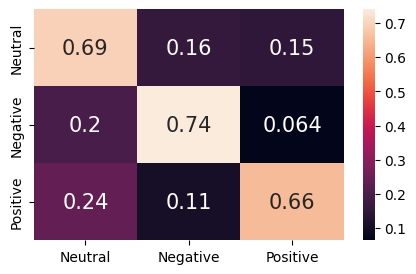

In [42]:
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (5,3))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})
plt.show()

In [43]:
sentiment = ['Neutral','Negative','Positive']

In [56]:
# loading tokenizer
tokenizer_pers = load('../artifacts/keras_tokenizer.joblib')

In [82]:
sequence = tokenizer_pers.texts_to_sequences(['this experience has been the worst , want my money back'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(persisted_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 32ms/step


'Negative'

In [61]:
sequence = tokenizer_pers.texts_to_sequences(['this data science article is the best ever'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(persisted_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 55ms/step


'Positive'

In [60]:
sequence = tokenizer_pers.texts_to_sequences(['i hate youtube ads, they are annoying'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(persisted_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 33ms/step


'Negative'

In [59]:
sequence = tokenizer_pers.texts_to_sequences(['i really loved how the technician helped me with the issue that i had'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(persisted_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 37ms/step


'Negative'

In [58]:
sequence = tokenizer_pers.texts_to_sequences(['this text will say normal stuff'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(persisted_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 33ms/step


'Positive'

In [ ]:
# testando prever um array